## Experimenting with the manually labelled data
___


In [1]:
%matplotlib inline
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)


In [2]:


import pandas as pd
import numpy as np
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from functools import lru_cache
from sklearn.cluster import KMeans, Birch, SpectralClustering, DBSCAN
from sklearn import mixture
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics

# initializing lemmatizer
stemmer = SnowballStemmer("english")
wordnet_lemmatizer = WordNetLemmatizer()
lemmatize = lru_cache(maxsize=50000)(wordnet_lemmatizer.lemmatize)
 
# ===========helper methods ========================================
def remove_non_ascii(s):
    return "".join(i for i in s if ord(i) < 128)

def stop_words_list():
    """
        A stop list specific to the observed timelines composed of noisy words
        This list would change for different set of timelines
    """
    stop_words = ['bc', 'http', 'https', 'co', 'rt', 'one', 'us', 'new',
              'lol', 'may', 'get', 'want', 'like', 'love', 'no', 'thank', 'would', 'thanks',
              'via', 'today', 'gt', 'great', 'watch', 'watched', 'season',
              '00p']

    stoplist  = set( nltk.corpus.stopwords.words("english") + stop_words)
    return stoplist

def remove_urls(text):
    text = re.sub(r"(?:\@|http?\://)\S+", "", text)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    return text

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return None

def tokenize(text):
    """
    helper function to readTweets() removes url and tokenizes text
    :param text
    """
    text = remove_urls(text)
    text = remove_non_ascii(text)
    text = re.sub(r"""[\'\"]""",'', text)
    regexps = (
        r"""(?:[\w_]+)""",                          # regular word
        r"""(?:[a-z][a-z'\-_]+[a-z])"""             # word with an apostrophe or a dash
    )
    tokens_regexp = re.compile(r"""(%s)""" % "|".join(regexps),
                               re.VERBOSE | re.I | re.UNICODE)
    return tokens_regexp.findall(text)

def replace_acronym(tokens, slang_dict):
    new_tokens = []
    for token in tokens:
        if token in slang_dict:
            new_tokens.extend(slang_dict[token].split())
        else:
            new_tokens.append(token)
    return new_tokens

def tokenize_and_lemmatize(text, slang_dict, stop_words):
    # get the tokens, lowercase - replace acronym
    lowered = [item.lower() for item in tokenize(text)]
    tokens = replace_acronym(lowered, slang_dict)

    
    tokens_pos = pos_tag(tokens)
    words = []
    for token in tokens_pos:
        pos = get_wordnet_pos(token[1])
        # if verb, noun, adj or adverb include them after lemmatization
        if pos is not None and token[0] not in stop_words:
            try:
                tok = lemmatize(token[0], pos)
                words.append(tok)
            except UnicodeDecodeError:
                pass
    # print words
    return words

def read_in_dict(filename):
    dict = {}
    with open(filename) as f:
        for line in f.readlines():
            parts = line.partition(":")
            dict[parts[0].strip()] = parts[2].strip()
    return dict

In [3]:
test_df = pd.read_csv("data/manually_labelled.csv",sep=';' , low_memory=False)

### Reading the data set int Pandas Dataframe :  
___

Snippet of the dataframe :  



In [4]:
print(test_df.tail())

         label                                              tweet   user_id
210  #personal  @ashleynconnor applying Chapstick after the de...  73306114
211  #personal  I need to remember to order my backpack tomorr...  73306114
212  #personal  RT @harto: remembering tomorrow is Friday is l...  73306114
213  #personal  @ittybittyanniee omg I am terrified to watch t...  73306114
214  #personal          #Scandalfinale tonight and I'm not ready.  73306114


In [5]:
print("Data Count: %d" % test_df.count()[0])
test_df.groupby('label').count()

Data Count: 215


,tweet,user_id
label,,
#ad,16,16
#business,11,11
#fashion,5,5
#job,1,1
#literature,2,2
#music,17,17
#personal,38,38
#politics,91,91
#tc,1,1


Count by User 

In [6]:
test_df.groupby(['user_id','label']).count()

tweet
user_id            label             
10023372           #politics        1
14734402           #politics        3
19087781           #politics        1
20942633           #business       11
24102642           #politics        2
24735229           #politics        1
26632132           #politics        2
29231236           #literature      2
                   #tv             18
48636686           #politics        2
58953182           #music           3
                   #personal        9
                   #tc              1
59598451           #fashion         1
73306114           #personal        7
                   #tv             13
187678724          #politics        3
189333010          #job             1
                   #music           1
                   #personal       16
                   #tv              2
209559590          #politics        2
211892358          #politics        1
344526913          #politics        3
359710029          #politics        2
382268135          #politics        2
419191691          #politics        3
588753363          #politics        4
611203907          #politics        2
902596597          #politics        5
916046030          #politics        2
963125190          #personal        3
1043408910         #politics        1
1230829058         #politics        1
1439285520         #politics        3
1621257068         #fashion         1
                   #politics        3
1639305888         #politics        1
2418179016         #politics        5
2638290883         #politics        2
2684239213         #fashion         1
                   #music           1
2787176905         #politics        4
2909475733         #politics        1
2973332381         #politics        3
2994953628         #ad             16
                   #music           1
                   #personal        3
3172753103         #music          10
3237942378         #politics        6
3317296048         #fashion         2
                   #music           1
3581658501         #politics        1
705261334875804000 #politics       19

#### Count of True Labels :
___


In [7]:
# true labels
t_labels = test_df.iloc[:, 0]
print (len(set(t_labels)))
print(set(t_labels))

10
{'#literature', '#business', '#tc', '#music', '#personal', '#fashion', '#ad', '#politics', '#tv', '#job'}


In [8]:
# convert the pandas series (tweet text) to numpy array
text = test_df.iloc[:, 1]
tweet_text = np.array(text)

### TFIDF 

`vectorizer = TfidfVectorizer(tokenizer=lambda text: tokenize_and_lemmatize(text, slang_dict, stop_words),
                                 stop_words=None,
                                 max_df=0.9,
                                 min_df=3,
                                 lowercase=True,
                                 decode_error='ignore',
                                 ) `

In [9]:
def get_tfidf_model(texts, stop_words= None, slang_dict=None):
    stop_words = stop_words_list()
    vectorizer = TfidfVectorizer(tokenizer=lambda text: tokenize_and_lemmatize(text, slang_dict, stop_words),
                                 stop_words=None,
                                 max_df=0.9,
                                 min_df=3,
                                 lowercase=True,
                                 decode_error='ignore',
                                 )

    #print ("vocabulary_: ", vectorizer.vocabulary_)
    
    tfidf_model = vectorizer.fit_transform(texts)
    return tfidf_model
    

slang_dict = read_in_dict("data/out_slang_map.csv")
tfidf_model = get_tfidf_model(tweet_text[:1000], stop_words_list(), slang_dict)
print("The dimension of TFIDF Model")
print(tfidf_model.shape)

The dimension of TFIDF Model
(215, 145)


### GMM for extimating the clusters :
___

Aikaki Information Criteria(AIC) and the Bayesian Information Criterion(BIC)


In [10]:
# gmm maximisation
clf = mixture.GMM(n_components=10, n_iter=500, n_init=10)
print (clf)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=10, n_init=10, n_iter=500, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)


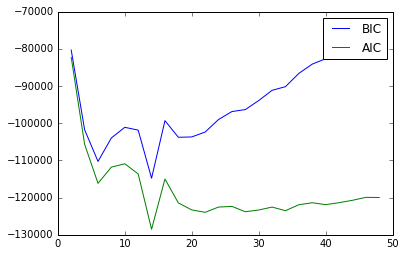

In [11]:
n_estimators = np.arange(2,50, step=2)
tfarray = tfidf_model.toarray()
clfs = [mixture.GMM(n, n_iter=500).fit(tfarray) for n in n_estimators]
bics = [clf.bic(tfarray) for clf in clfs]
aics = [clf.aic(tfarray) for clf in clfs]

plt.plot(n_estimators, bics, label= 'BIC')
plt.plot(n_estimators, aics, label= 'AIC')
plt.legend()

n             bic              aic 
2             -80341              -82299
3             -96605              -99544
4             -99882              -103802
5             -108790              -113691
6             -95042              -100923
7             -114560              -121423
8             -114261              -122104
9             -96225              -105049


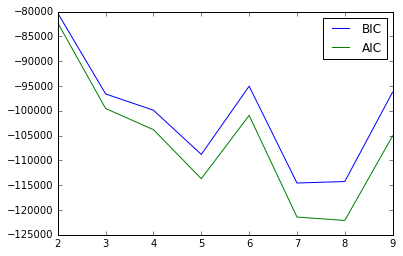

In [12]:
n_estimators = np.arange(2,10, step=1)
tfarray = tfidf_model.toarray()
clfs = [mixture.GMM(n, n_iter=500).fit(tfarray) for n in n_estimators]
bics = [clf.bic(tfarray) for clf in clfs]
aics = [clf.aic(tfarray) for clf in clfs]

plt.plot(n_estimators, bics, label= 'BIC')
plt.plot(n_estimators, aics, label= 'AIC')
plt.legend()

i = 1
print("n             bic              aic ")
for x, y in zip(bics, aics):
    i += 1
    print("%d             %d              %d" % (i, x, y) )

In [13]:
# Log probabilities of each data point in tfarray
clf = mixture.GMM(n_components=9, n_iter=500).fit(tfarray)
#print( clf.score(tfarray))


### clustering using n = 8

####  Kmeans:

In [14]:

# run k means :
clusters = 8
km_model = KMeans(n_clusters=clusters)
cluster = km_model.fit_predict(tfidf_model)

# result analysis :
print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))

Silhouette score                   : 0.157615
Adjusted Rand Score                : 0.190748
Adjusted Mutual Information Score  : 0.330925
Normalized Mutual Information Score: 0.389722
Normalized Mutual Information Score: 0.389722
Homogeniety Score                  : 0.396766
Completeness Score                 : 0.382803


#### Birch Clustering:

In [15]:
# run Birch:
birch = Birch(n_clusters=clusters)
cluster = birch.fit_predict(tfidf_model)

# result analysis :
print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))

Silhouette score                   : 0.069237
Adjusted Rand Score                : -0.023531
Adjusted Mutual Information Score  : 0.125703
Normalized Mutual Information Score: 0.205948
Normalized Mutual Information Score: 0.205948
Homogeniety Score                  : 0.189797
Completeness Score                 : 0.223474


#### SpectralClustering

In [16]:
# run SpectralClustering
spectral = SpectralClustering(n_clusters=clusters,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
cluster = spectral.fit_predict(tfidf_model)

# result analysis :
print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))

Silhouette score                   : -0.059674
Adjusted Rand Score                : 0.133874
Adjusted Mutual Information Score  : 0.179747
Normalized Mutual Information Score: 0.289356
Normalized Mutual Information Score: 0.289356
Homogeniety Score                  : 0.239352
Completeness Score                 : 0.349807


/home/swati/anaconda3/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:217: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


#### DBSCAN

In [17]:
# db scan
dbscan = DBSCAN(eps=.2)
cluster = dbscan.fit_predict(tfidf_model)
print("clusters by DBSCAN: %d" % len(set(cluster)))
# result analysis :
print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))


clusters by DBSCAN: 4
Silhouette score                   : -0.061650
Adjusted Rand Score                : 0.121870
Adjusted Mutual Information Score  : 0.166260
Normalized Mutual Information Score: 0.318049
Normalized Mutual Information Score: 0.318049
Homogeniety Score                  : 0.193501
Completeness Score                 : 0.522765


### Discussion :
___

* Manual labelling is very subjecting and personally I was not able to give labels to many tweets as they had very vague meaning
* The count of tweets per label are very different ( I will try to pick a sample of tweets with better distribution next
* GMM : is helpful in coming up with cluster counts using EM
* K means seem to perform better than any other clustering 